In [1]:
import sys; sys.path.append('../')
from AffineFace import Image
import numpy as np
import matplotlib.pyplot as plt
import dlib
from urllib.request import urlretrieve
import bz2
from zipfile import ZipFile
from io import BytesIO

In [2]:
url = 'http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2'
filepath  = urlretrieve(url)[0]
data = bz2.BZ2File(filepath).read()
with open(filepath, 'wb') as f:
    f.write(data)

predictor = dlib.shape_predictor(filepath)
detector = dlib.get_frontal_face_detector()

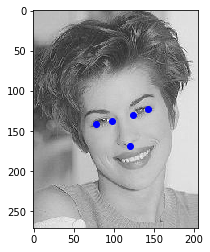

In [3]:
face = Image('face.png')

face_array = np.array(face.im)
frame = detector(face_array)[0]
sp = predictor(face_array, frame)

landmarks = np.array([[sp.part(i).x, sp.part(i).y] for i in range(5)])

plt.scatter(landmarks[:,0], landmarks[:,1], color='blue')
plt.imshow(face.im, cmap='gray')

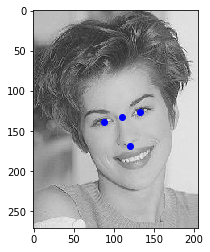

In [4]:
eye1 = np.mean(landmarks[0:2], axis=0)
eye2 = np.mean(landmarks[2:4], axis=0)
mid_eye = np.mean([eye1, eye2], axis=0)
nose = landmarks[-1]

landmarks = np.stack([eye1, eye2, mid_eye, nose])

plt.scatter(landmarks[:,0], landmarks[:,1], color='blue')
plt.imshow(face.im, cmap='gray')

In [5]:
kwargs = {
    'eyes_distance': 100,
    'x_offset': 50, 
    'y_offset': 50,
    'size': (200, 250),
}

In [6]:
similarity_im, similarity_matrix = face.align((eye2, eye1), **kwargs)

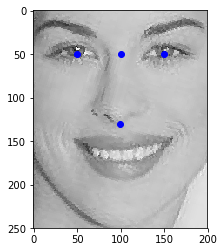

In [7]:
warp = lambda mat, x: mat.dot(np.append(x, 1).reshape(-1, 1))[:2].ravel()
similarity_landmarks = np.array([warp(similarity_matrix, landmark) for landmark in landmarks])

plt.scatter(similarity_landmarks[:,0], similarity_landmarks[:,1], color='blue')
plt.imshow(similarity_im, cmap='gray')

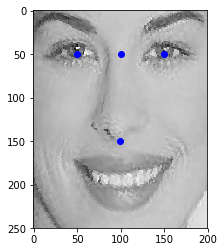

In [8]:
kwargs['aux'] = nose
kwargs['aux_distance'] = 100

affine_im, affine_matrix = face.align((eye2, eye1), **kwargs)
affine_landmarks = np.array([warp(affine_matrix, landmark) for landmark in landmarks])

plt.scatter(affine_landmarks[:,0], affine_landmarks[:,1], color='blue')
plt.imshow(affine_im, cmap='gray')

In [9]:
url_list = [
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part1.zip',
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part2.zip',
]

archive = [ZipFile(urlretrieve(url)[0], 'r') for url in url_list]
images = [image for zipfile in archive for image in zipfile.namelist()]

In [10]:
neutral = {'filename': [], 'obj': [], 'face': [], '5_landmarks':[]}
smiling = {'filename': [], 'obj': [], 'face': [], '5_landmarks':[]}

for image in images:
    try:
        face = Image(BytesIO(archive[0].read(image)))
    except:
        face = Image(BytesIO(archive[1].read(image)))
    
    face_array = np.array(face.im)
    frame = detector(face_array)[0]
    sp = predictor(face_array, frame)
    landmarks = np.array([[sp.part(i).x, sp.part(i).y] for i in range(5)])
    
    if 'a' in image:
        neutral['filename'].append(image)
        neutral['obj'].append(face)
        neutral['face'].append(face_array)
        neutral['5_landmarks'].append(landmarks)
        
    if 'b' in image:
        smiling['filename'].append(image)
        smiling['obj'].append(face)
        smiling['face'].append(face_array)
        smiling['5_landmarks'].append(landmarks)

In [11]:
for image in [neutral, smiling]:
    image['mean'] = {}
    image['mean']['face'] = np.mean(image['face'], axis=0)
    image['mean']['5_landmarks'] = np.mean(image['5_landmarks'], axis=0)
    image['mean']['eye1'] = np.mean(image['mean']['5_landmarks'][2:4], axis=0)
    image['mean']['eye2'] = np.mean(image['mean']['5_landmarks'][0:2], axis=0)
    image['mean']['mid_eye'] = (image['mean']['eye1'] + image['mean']['eye2']) / 2
    image['mean']['nose'] = image['mean']['5_landmarks'][-1]
    image['mean']['landmarks'] = np.stack(list(image['mean'].values())[-4:])

(-0.5, 259.5, 359.5, -0.5)

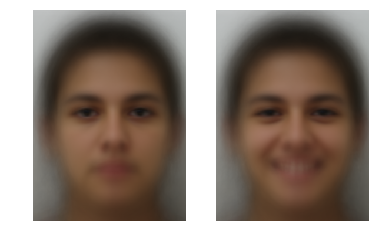

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(neutral['mean']['face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smiling['mean']['face'].astype(np.uint8))
plt.axis('off')

(-0.5, 259.5, 359.5, -0.5)

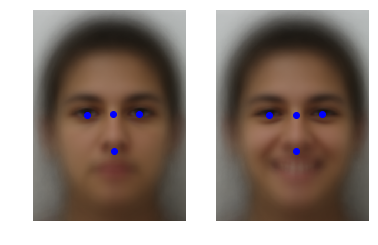

In [13]:
plt.subplot(1, 2, 1)
plt.scatter(neutral['mean']['landmarks'][:,0], neutral['mean']['landmarks'][:,1], c='b')
plt.imshow(neutral['mean']['face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(smiling['mean']['landmarks'][:,0], smiling['mean']['landmarks'][:,1], c='b')
plt.imshow(smiling['mean']['face'].astype(np.uint8))
plt.axis('off')

In [14]:
for image in [neutral, smiling]:
    image['kwargs'] = {}
    image['kwargs']['eyes_distance'] = image['mean']['eye2'][0] - image['mean']['eye1'][0]
    image['kwargs']['aux_distance'] = image['mean']['nose'][1] - image['mean']['mid_eye'][1]
    image['kwargs']['x_offset'] = image['mean']['eye1'][0]
    image['kwargs']['y_offset'] = image['mean']['eye1'][1]

print('Neutral kwargs:')
for key, value in neutral['kwargs'].items():
    print('%s = %d pixels' %(key, value))
    
print('\nSmiling kwargs:')
for key, value in smiling['kwargs'].items():
    print('%s = %d pixels' %(key, value))

Neutral kwargs:
eyes_distance = 89 pixels
aux_distance = 63 pixels
x_offset = 91 pixels
y_offset = 177 pixels

Smiling kwargs:
eyes_distance = 90 pixels
aux_distance = 62 pixels
x_offset = 90 pixels
y_offset = 178 pixels


In [15]:
for image in [neutral, smiling]:
    image['similarity_face'] = []
    image['affine_face'] = []
    for face, landmarks in zip(image['obj'], image['5_landmarks']):
        eye1 = np.mean(landmarks[2:4], axis=0)
        eye2 = np.mean(landmarks[0:2], axis=0)
        nose = landmarks[-1]
        
        similarity_im, _ = face.align((eye1, eye2), **image['kwargs'])
        affine_im, _ = face.align((eye1, eye2), aux=nose, **image['kwargs'])
        
        image['similarity_face'].append(np.array(similarity_im))
        image['affine_face'].append(np.array(affine_im))
    
    image['mean']['similarity_face'] = np.mean(image['similarity_face'], axis=0)
    image['mean']['affine_face'] = np.mean(image['affine_face'], axis=0)

(-0.5, 259.5, 359.5, -0.5)

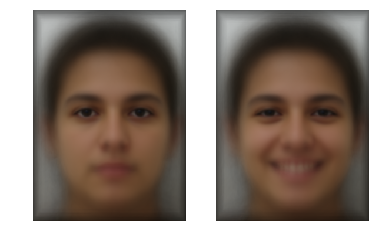

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(neutral['mean']['similarity_face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smiling['mean']['similarity_face'].astype(np.uint8))
plt.axis('off')

(-0.5, 259.5, 359.5, -0.5)

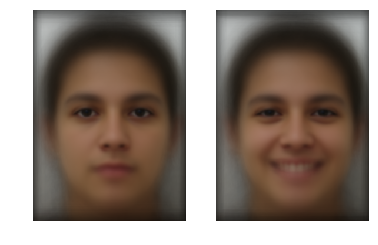

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(neutral['mean']['affine_face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smiling['mean']['affine_face'].astype(np.uint8))
plt.axis('off')

In [18]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
filepath  = urlretrieve(url)[0]
data = bz2.BZ2File(filepath).read()
with open(filepath, 'wb') as f:
    f.write(data)

predictor = dlib.shape_predictor(filepath)

In [19]:
neutral['68_landmarks'] = []
smiling['68_landmarks'] = []

for i, image in enumerate([neutral, smiling]):
    for face_array in image['face']:
        frame = detector(face_array)[0]
        sp = predictor(face_array, frame)
        landmarks = np.array([[sp.part(i).x, sp.part(i).y] for i in range(68)])
        
        if i == 0:
            neutral['68_landmarks'].append(landmarks)
            
        if i == 1:
            smiling['68_landmarks'].append(landmarks)

In [20]:
for image in [neutral, smiling]:
    image['mean'] = {}
    image['mean']['face'] = np.mean(image['face'], axis=0)
    image['mean']['68_landmarks'] = np.mean(image['68_landmarks'], axis=0)
    image['mean']['eye1'] = np.mean(image['mean']['68_landmarks'][[37,38,40,41]], axis=0)
    image['mean']['eye2'] = np.mean(image['mean']['68_landmarks'][[43,44,46,47]], axis=0)
    image['mean']['mid_eye'] = (image['mean']['eye1'] + image['mean']['eye2']) / 2
    image['mean']['mouth'] = np.mean(image['mean']['68_landmarks'][[61,62,63,65,66,67]], axis=0)
    image['mean']['landmarks'] = np.stack(list(image['mean'].values())[-4:])

(-0.5, 259.5, 359.5, -0.5)

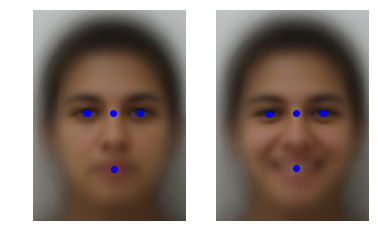

In [21]:
plt.subplot(1, 2, 1)
plt.scatter(neutral['mean']['landmarks'][:,0], neutral['mean']['landmarks'][:,1], c='b')
plt.imshow(neutral['mean']['face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(smiling['mean']['landmarks'][:,0], smiling['mean']['landmarks'][:,1], c='b')
plt.imshow(smiling['mean']['face'].astype(np.uint8))
plt.axis('off')

In [22]:
for image in [neutral, smiling]:
    image['kwargs'] = {}
    image['kwargs']['eyes_distance'] = image['mean']['eye2'][0] - image['mean']['eye1'][0]
    image['kwargs']['aux_distance'] = image['mean']['mouth'][1] - image['mean']['mid_eye'][1]
    image['kwargs']['x_offset'] = image['mean']['eye1'][0]
    image['kwargs']['y_offset'] = image['mean']['eye1'][1]

print('Neutral kwargs:')
for key, value in neutral['kwargs'].items():
    print('%s = %d pixels' %(key, value))
    
print('\nSmiling kwargs:')
for key, value in smiling['kwargs'].items():
    print('%s = %d pixels' %(key, value))

Neutral kwargs:
eyes_distance = 90 pixels
aux_distance = 95 pixels
x_offset = 91 pixels
y_offset = 176 pixels

Smiling kwargs:
eyes_distance = 91 pixels
aux_distance = 93 pixels
x_offset = 90 pixels
y_offset = 176 pixels


In [23]:
for image in [neutral, smiling]:
    image['affine_face'] = []
    for face, landmarks in zip(image['obj'], image['68_landmarks']):
        eye1 = np.mean(landmarks[[37,38,40,41]], axis=0)
        eye2 = np.mean(landmarks[[43,44,46,47]], axis=0)
        mouth = np.mean(landmarks[[61,62,63,65,66,67]], axis=0)
        
        affine_im, _ = face.align((eye1, eye2), aux=mouth, **image['kwargs'])
        image['affine_face'].append(np.array(affine_im))
    
    image['mean']['affine_face'] = np.mean(image['affine_face'], axis=0)

(-0.5, 259.5, 359.5, -0.5)

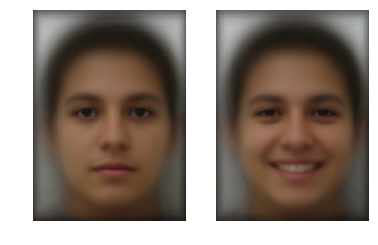

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(neutral['mean']['affine_face'].astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smiling['mean']['affine_face'].astype(np.uint8))
plt.axis('off')